# PA005: High Values Customer Identification ( Insiders )

# 0.0. Planejamento da Solução ( IOT )

### Input - Entrada

1. Problema de Negócio
 - Selecionar os clientes mais valiosos para integrar um programa de Fidelização
2. Conjunto de Dados
 - Vendas de um e-commerce online, durante o periodo de um ano.

### Ouput - Saída

1. A indicação de pessoas para fazer parte do programa de fidelidade "INSIDERS".
    - Lista: client_id | is_insider |
               10235 | yes/1
               25482 | no/0

2. Relatório com as respostas para as seguintes perguntas:
    - Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - Quantos clientes farão parte do grupo?Quais as principais características desses clientes ?
    - Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Quais as condições para uma pessoa ser removida do Insiders ?
    - Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?

### Task - Tarefas

1. Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - O que é ser elegível ? O que é um cliente "valioso" para a empresa ?
    - Faturamento:
        - Alto Ticket Médio ( média de gastos )
        - Alto LTV ( total de gasto )
        - Baixa Recência ou Alta Frequência ( tempo entre as compras )
        - Alto Basket Size ( quantidade média de produtos comprados )
        - Baixa probabilidade de Churn
        - Previsão alta de LTV
        - Alta propensão de compra

    - Custo:
        - Baixo número de devoluções
        
    - Experiência:  
        - Média alta de avaliações

2. Quantos clientes farão parte do grupo?
    - Número de clientes
    - % em relação ao total de clients

3. Quais as principais características desses clientes ?
    - Escrever os principais atributos dos clientes
        - Idade
        - País
        - Salário
        
    Escrever os principais comportamentos de compra dos clients ( métricas de negócio ) Vide acima

4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Calcular o faturamento total da empresa durante o ano.
    - Calcular o faturamento (%) apenas do cluster Insiders.
    

5. Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - Cálculo do LTV do grupo InsidersSéries Temporais ( ARMA, ARIMA, HoltWinter, etc )
    

6. Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Qual o período de avaliação ?
    - O "desempenho" do cliente está próximo da média do cluster Insiders. 
    

7. Quais as condições para uma pessoa ser removida do Insiders ?
    - O "desempenho" do cliente não está mais próximo da média do cluster Insiders. 
    

8. Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Teste de Hipóteses
    - Teste A/B
    

9. Quais ações o time de marketing pode realizar para aumentar o faturamento?
    - Descontos
    - Preferências de escolha
    - Produtos exclusivos

# 0.0 Imports

In [84]:
import pandas as pd
import numpy as np
import seaborn as sns

import umap.umap_ as umap

from plotly import express as px

from sklearn import cluster as c
from sklearn import metrics as m

from IPython.display     import HTML
from matplotlib          import pyplot as plt

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer 

## 0.1. Helper Functions

In [85]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot' )
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()    


jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/opt/anaconda/envs/pa005_insiders_clustering/lib/python3.9/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['mod']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2. Load dataset

In [86]:
# load data
df_raw = pd.read_csv( '../data/raw/Ecommerce.csv', encoding='unicode_escape')

# drop extra column
df_raw = df_raw.drop( columns=['Unnamed: 8'], axis=1 )

# <font color='red'> 1.0. Descrição dos dados </font>

In [87]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [88]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2. Data Dimensions

In [89]:
print( f'Number of rows: {df1.shape[0]}')
print( f'Number of cols: {df1.shape[1]}')

Number of rows: 541909
Number of cols: 8


## 1.3. Data Types

In [90]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [91]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [92]:
df1 = df1.dropna( subset=['description', 'customer_id'] )
print( f'Removed data: {1-(df1.shape[0] / df_raw.shape[0] ) :.2f}')

Removed data: 0.25


In [93]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 1.6. Change Dtypes

In [94]:
# invoice date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y' )

# customer id
df1['customer_id'] = df1['customer_id'].astype( int )
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


In [95]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

## 1.7. Descriptive Statistics

# <font color='red'> 2.0. Feature Engineering </font>

In [96]:
df2 = df1.copy()

## 2.1. Feature Creation

In [97]:
# data reference
df_ref = df2.drop( ['invoice_no', 'stock_code', 'description',
                    'quantity', 'invoice_date', 'unit_price', 
                    'country'], axis=1 ).drop_duplicates( ignore_index=True )


# Gross Revenue ( Faturamento ) quantity * price
df2['gross_revenue'] = df2['quantity'] * df2['unit_price']

# Monetary
df_monetary = df2[['customer_id', 'gross_revenue']].groupby( 'customer_id' ).sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left')

# Recency - Last day purchase
df_recency = df2[['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df2['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left')

# Frequency
df_freq = df2[['customer_id', 'invoice_no']].drop_duplicates().groupby( 'customer_id' ).count().reset_index()
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left')


# ====== ciclo 2 ======
df_avg_ticket = df2[['customer_id', 'gross_revenue']].groupby( 'customer_id' ).mean().reset_index().rename( columns={'gross_revenue':'avg_ticket'} )
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left')

df_ref.isna().sum() # -> Check NA apos merge

customer_id      0
gross_revenue    0
recency_days     0
invoice_no       0
avg_ticket       0
dtype: int64

In [98]:
df_ref.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket
0,17850,5288.63,302,35,16.950737
1,13047,3079.10,31,18,15.709694
2,12583,7187.34,2,18,28.634821
3,13748,948.25,95,5,33.866071
4,15100,635.10,330,6,105.850000


# <font color='red'> 3.0. Filtragem de Variavéis </font>

In [99]:
df3 = df_ref.copy()

# <font color='red'> 4.0. EDA (Exploratory Data Analysis) </font>

In [100]:
df4 = df3.copy()

# <font color='red'> 5.0. Data Preparation </font>

In [101]:
df5 = df4.copy()

# <font color='red'> 6.0. Feature Selection </font>

In [102]:
df6 = df5.copy()

# <font color='red'> 7.0. Hyperparameter Fine-Tunning </font>

In [103]:
X = df6.drop( columns=['customer_id'])

In [104]:
clusters = [ 2, 3, 4, 5, 6, 7]

## 7.1. Within-Cluster Sum of Square ( WSS )

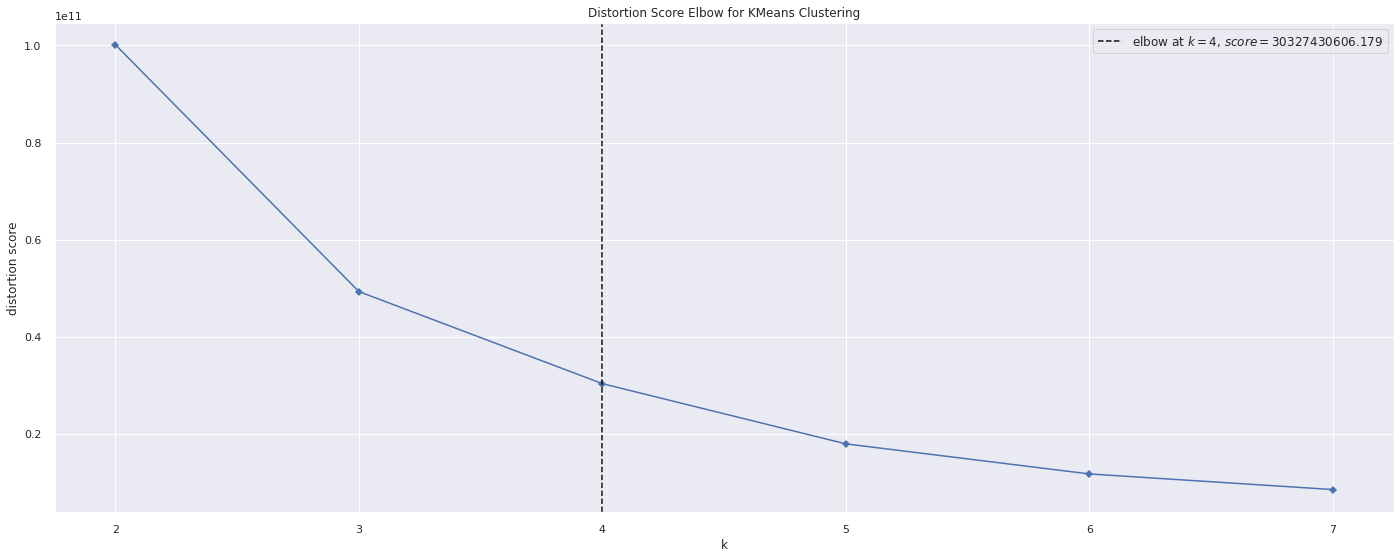

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [106]:
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, timings=False )
kmeans.fit( X )
kmeans.show()

## 7.2. Sillhouette Score

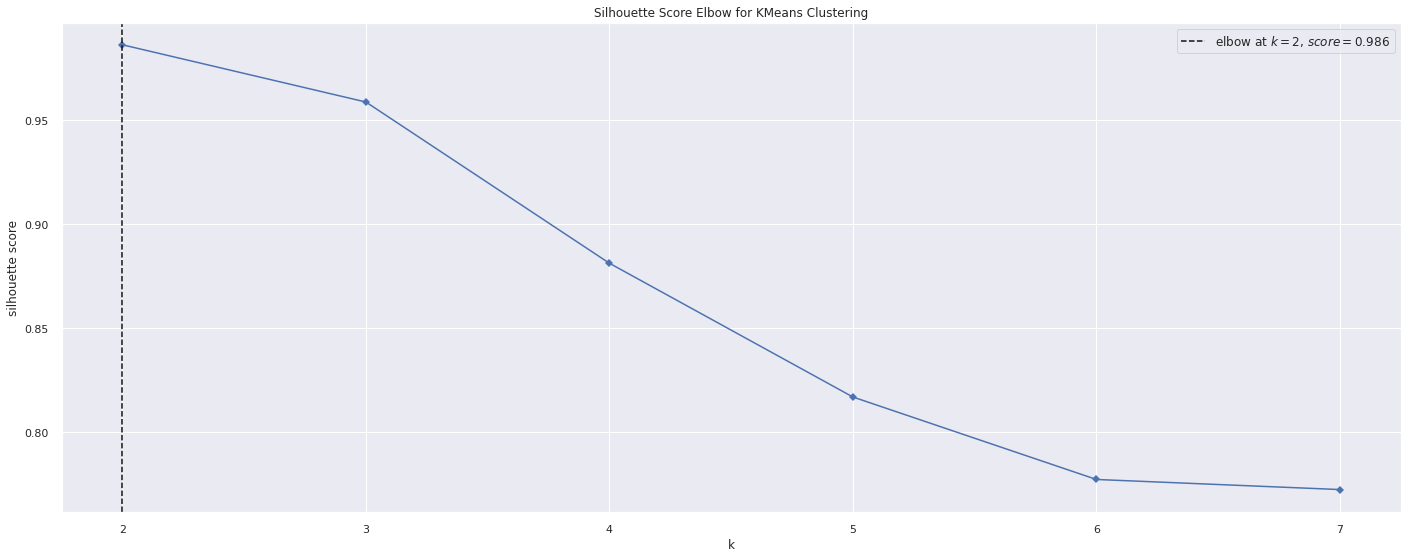

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [107]:
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, metric='silhouette', timings=False )
kmeans.fit( X )
kmeans.show()

## 7.3. Silhouette Analysis

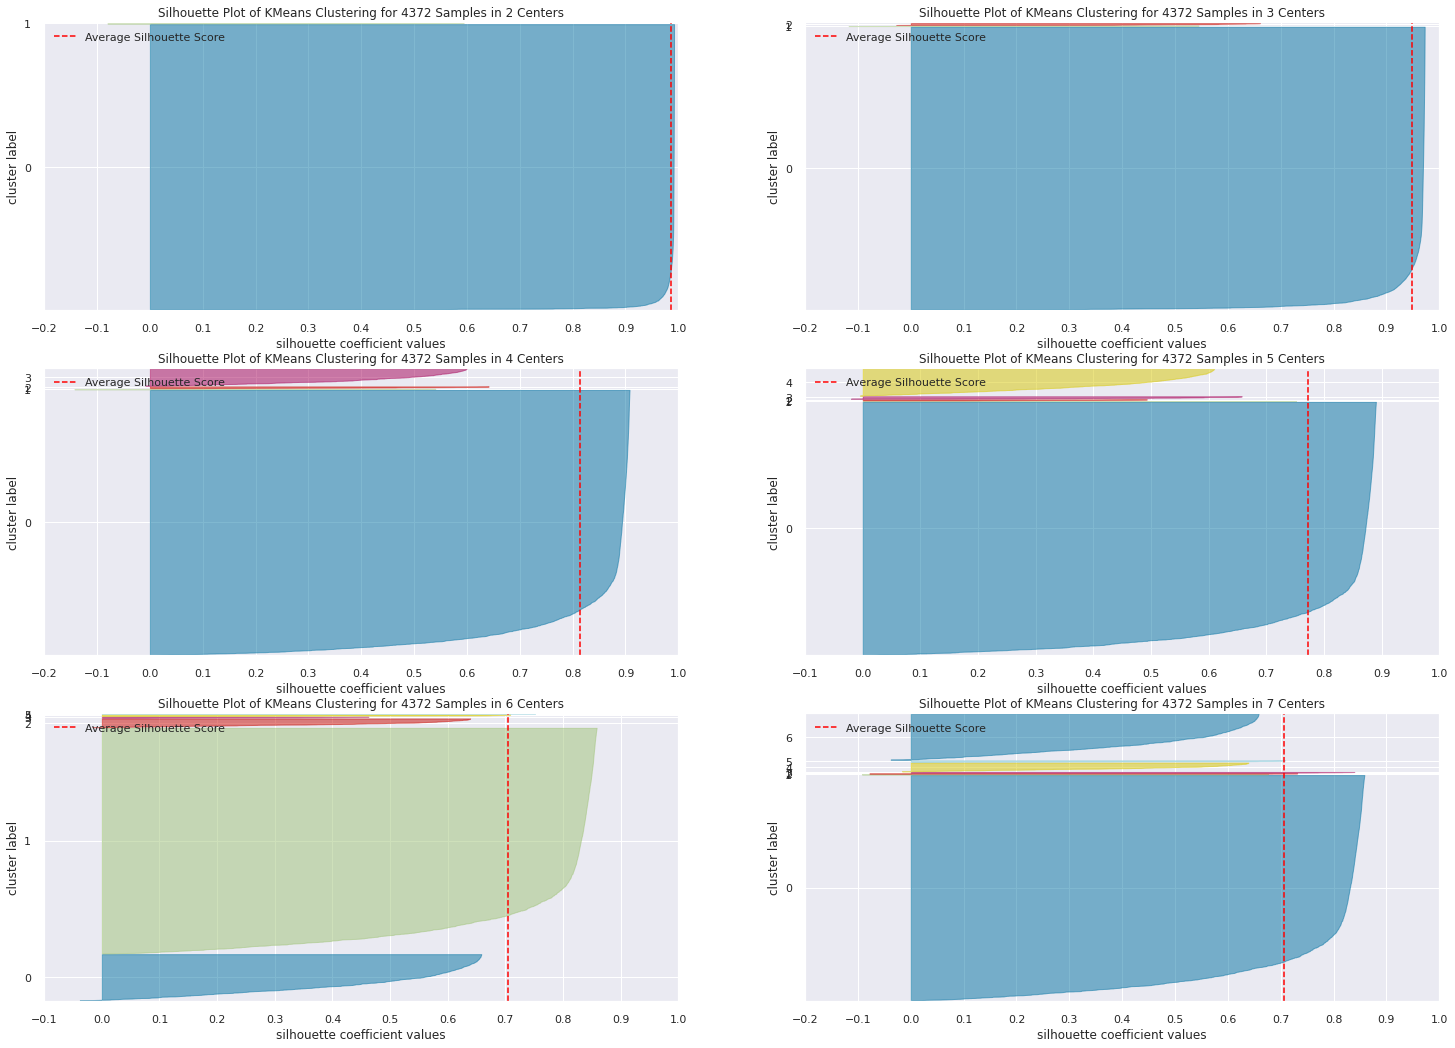

In [108]:
fig, ax = plt.subplots( 3, 2, figsize=(25, 18) )

for k in clusters:
    km = c.KMeans( n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42 )
    q, mod = divmod( k, 2 )
    
    visualizer = SilhouetteVisualizer( km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit( X )
    visualizer.finalize()

# <font color='red'> 8.0. Model Training </font>

## 8.1. K-Means

In [109]:
# model definition
k = 4 
kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42 )

# model training
kmeans.fit( X )

# clustering
labels = kmeans.labels_

## 8.1. Clusters Validation

In [110]:
# WSS ( Within-cluter sum of square )
print( f'WSS Value: { kmeans.inertia_}')

# SS ( Silhouette Score )
print( f'SS Value: { m.silhouette_score( X, labels, metric="euclidean")}')

WSS Value: 40056506734.60246
SS Value: 0.8139972028952444


# <font color='red'> 9.0. Cluster Analysis </font>

In [111]:
df9 = df6.copy()
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
0,17850,5288.63,302,35,16.950737,3
1,13047,3079.10,31,18,15.709694,0
2,12583,7187.34,2,18,28.634821,3
3,13748,948.25,95,5,33.866071,0
4,15100,635.10,330,6,105.850000,0


## 9.1. Visualization Inspection

/opt/anaconda/envs/pa005_insiders_clustering/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


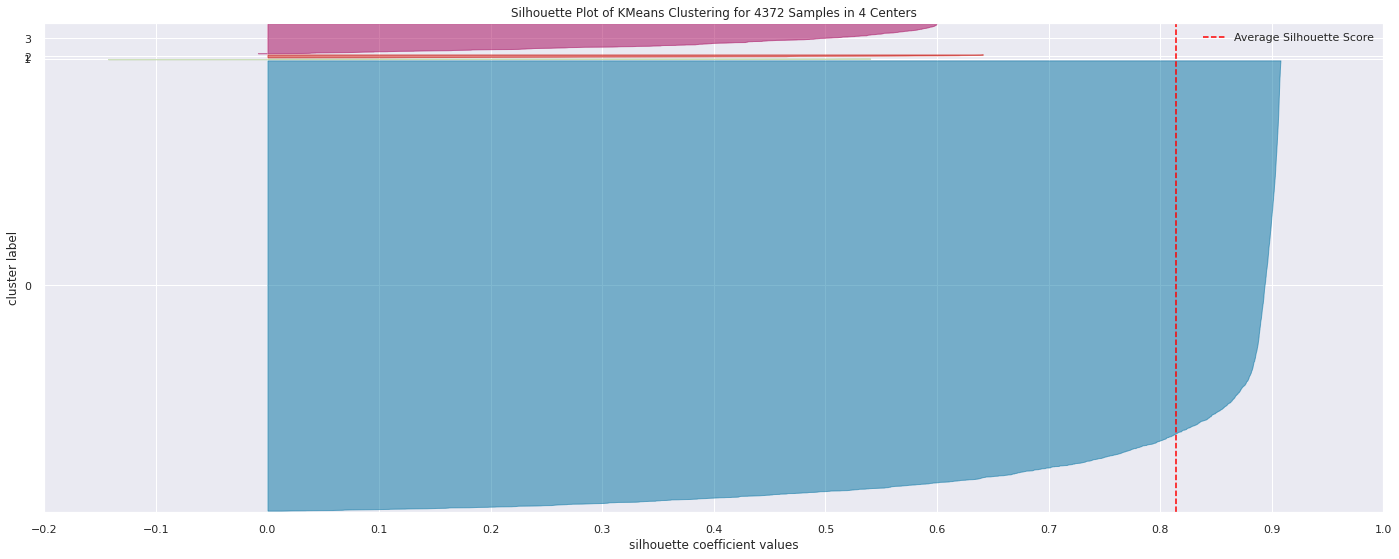

In [112]:
visualizer = SilhouetteVisualizer( kmeans, colors='yellowbrick')
visualizer.fit( X )
visualizer.finalize()

## 9.2. 2d plot

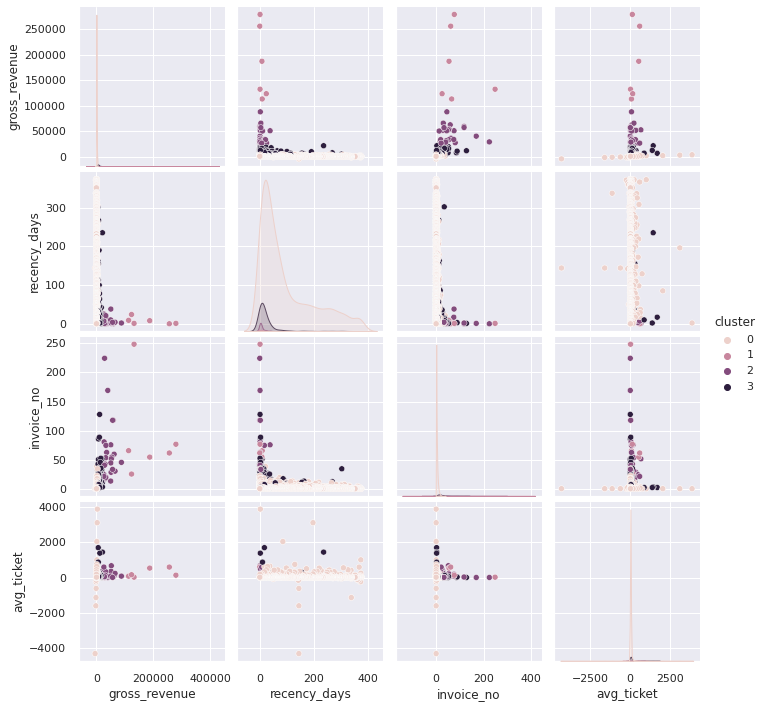

In [113]:
df_viz = df9.drop( columns='customer_id', axis=1 )
sns.pairplot( df_viz, hue='cluster')

## 9.3. UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

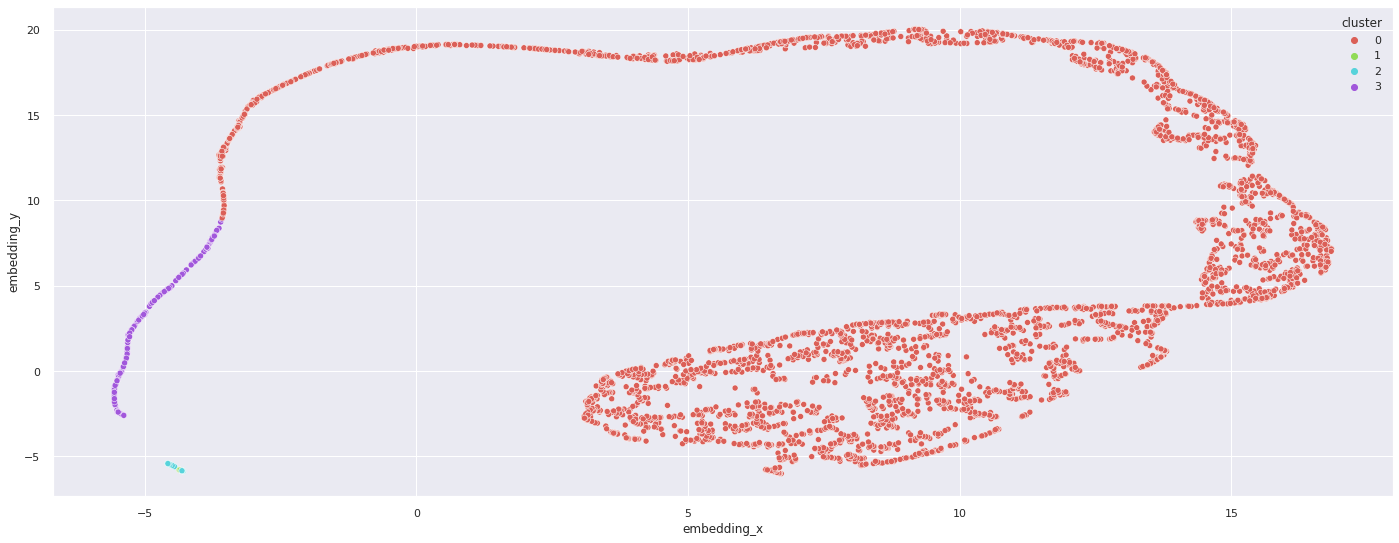

In [114]:
reducer = umap.UMAP( n_neighbors=20, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', y='embedding_y',
               hue='cluster',
               palette=sns.color_palette( 'hls', n_colors=len( df_viz['cluster'].unique() ) ),
               data=df_viz )

## 9.1. Cluster Profile

In [116]:
# Number of customer
df_cluster = df9[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Avg recency days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster')

# Avg invoice_no
df_avg_invoice_no = df9[['invoice_no', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_invoice_no, how='inner', on='cluster')

#Avg Ticket
df_ticket = df9[['avg_ticket', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_ticket, how='inner', on='cluster')

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,4071,93.115279,946.696250,96.969295,3.641120,25.359654
1,1,6,0.137237,182181.981667,7.166667,89.000000,253.626345
2,2,28,0.640439,42614.387143,6.178571,57.821429,162.862605
3,3,267,6.107045,8089.028652,20.280899,19.528090,62.783157


### Cluster 00:  
- Número de customers: 4071 (93% do customers )
- Recência em média: 96 dias
- Compras em média: 4 compras
- Receita em média: 946,00 dólares
- Ticket médio: 25,00 dólares

### Cluster 01: 
- Número de customers: 6 (0.14% do customers )
- Recência em média: 7 dias
- Compras em média: 89 compras
- Receita em média: 182.182,00 dólares
- Ticket médio: 254,00 dólares

### Cluster 02:
- Número de customers: 28 (0.64 do customers )
- Recência em média: 6 dias
- Compras em média: 57 compras
- Receita em média: 42.614,38 dólares
- Ticket médio: 163,00 dólares

### Cluster 03:
- Número de customers: 267 (6% do customers )
- Recência em média: 20 dias
- Compras em média: 19 compras
- Receita em média: 8.089,02 dólares
- Ticket médio: $63,00 dólares


# <font color='red'> 10.0. Deploy To Production </font>